# **Import necessary libraries**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score

# **Load cifar100 datasets**

In [2]:
(full_train_x, full_train_y), (test_x, test_y) = keras.datasets.cifar100.load_data()
full_train_x.shape, full_train_y.shape, test_x.shape, test_y.shape

169017344/169001437 [==============================] - 3s 0us/step


((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [3]:
np.unique(full_train_y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [4]:
full_train_y[0]

array([19])

# **Create cross-validation set**

In [5]:
train_x, val_x, train_y, val_y = train_test_split(full_train_x, full_train_y, test_size = 0.2)
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (40000, 1), (10000, 1))

# **Normalize data**

In [6]:
train_x.shape, val_x.shape, train_x[0].shape, val_x[0].shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (32, 32, 3), (32, 32, 3))

In [7]:
train_y = keras.utils.to_categorical(train_y)
val_y = keras.utils.to_categorical(val_y)
test_y = keras.utils.to_categorical(test_y)

In [8]:
train_y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

# **Labels**

In [9]:
labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# **Data augmentation**

In [10]:
# Train datagen
train_datagen = ImageDataGenerator(
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode = 'nearest',
        featurewise_center = True,
        featurewise_std_normalization = True,
)

train_datagen.fit(train_x)
train_generator = train_datagen.flow(train_x, train_y, batch_size = 64)

# Valid datagen
valid_datagen = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True,
)

valid_datagen.fit(val_x)
valid_generator = valid_datagen.flow(val_x, val_y, batch_size = 64)

# Test datagen
test_datagen = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True,
)

test_datagen.fit(test_x)
test_generator = test_datagen.flow(test_x, test_y, batch_size = 64)

# **Create model**

**Custom model with 3 CNNs and 1 FC**

In [11]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(128, (3, 3), padding = 'same', input_shape = (32, 32, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Conv2D(128, (3, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Conv2D(256, (3, 3), padding = 'same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Conv2D(256, (3, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(512, (3, 3), padding = 'same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Conv2D(512, (3, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.4))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(100))
model.add(keras.layers.Activation('softmax'))

# **Model architecture**

In [21]:
#@title
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 128)       147584    
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 128)      512       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 30, 30, 128)       0

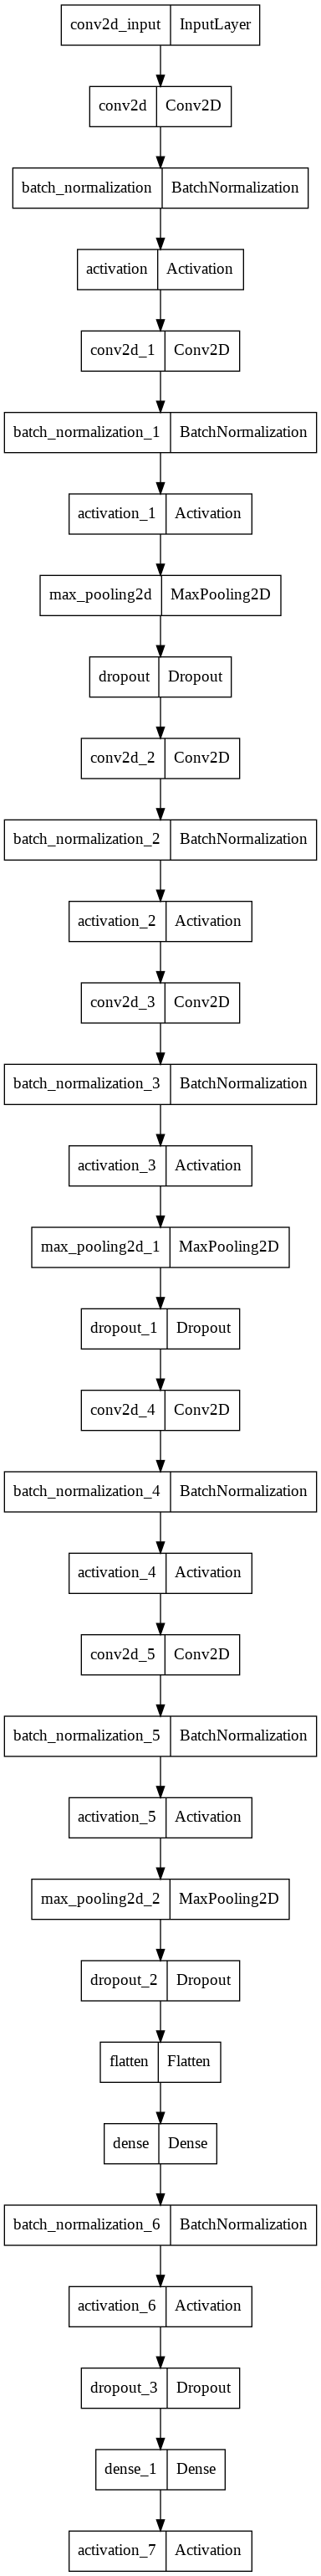

In [22]:
#@title
keras.utils.plot_model(model)

# **Compile model**

In [12]:
num_epoch = 100

In [13]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = keras.optimizers.Adam(learning_rate = 1e-4, clipvalue = 0.2),
    metrics = ['accuracy'],
)

# **Train model**

In [14]:
history = model.fit(train_generator, epochs = num_epoch, validation_data = valid_generator, batch_size = 64)

Epoch 1/100
625/625 [==============================] - 87s 87ms/step - loss: 4.3114 - accuracy: 0.0689 - val_loss: 3.7017 - val_accuracy: 0.1372
Epoch 2/100
625/625 [==============================] - 54s 86ms/step - loss: 3.7314 - accuracy: 0.1325 - val_loss: 3.3399 - val_accuracy: 0.1942
Epoch 3/100
625/625 [==============================] - 54s 87ms/step - loss: 3.3937 - accuracy: 0.1865 - val_loss: 3.1013 - val_accuracy: 0.2395
Epoch 4/100
625/625 [==============================] - 54s 87ms/step - loss: 3.1195 - accuracy: 0.2308 - val_loss: 2.8494 - val_accuracy: 0.2894
Epoch 5/100
625/625 [==============================] - 54s 86ms/step - loss: 2.9052 - accuracy: 0.2699 - val_loss: 2.6579 - val_accuracy: 0.3255
Epoch 6/100
625/625 [==============================] - 54s 87ms/step - loss: 2.7338 - accuracy: 0.3031 - val_loss: 2.4831 - val_accuracy: 0.3591
Epoch 7/100
625/625 [==============================] - 54s 87ms/step - loss: 2.6023 - accuracy: 0.3271 - val_loss: 2.4190 - val_ac

# **Plot graph**

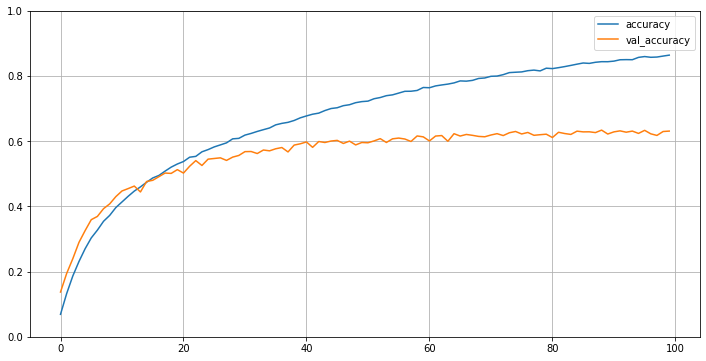

In [15]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize = (12, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

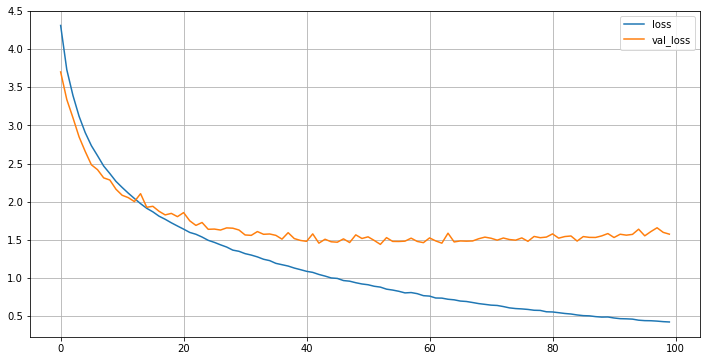

In [16]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize = (12, 6))
plt.grid(True)
plt.show()

# **Evaluate**

In [17]:
model.evaluate(test_generator)

157/157 [==============================] - 4s 24ms/step - loss: 1.5035 - accuracy: 0.6398


[1.5035274028778076, 0.6398000121116638]

In [18]:
pred_y = model.predict(test_generator)

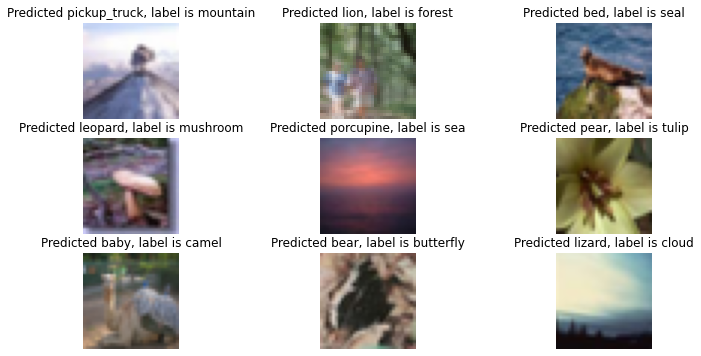

In [20]:
# Analyze 9 cases
plt.figure(figsize = (12, 6))

idx = 0
for i in range(pred_y.shape[0]):
  predicted = np.argmax(pred_y[i])
  true_label = np.argmax(test_y[i])
  if predicted != true_label:
    idx += 1
    plt.subplot(3, 3, idx)
    plt.title(f'Predicted {labels[predicted]}, label is {labels[true_label]}')
    plt.imshow(test_x[i])
    plt.axis('off')

    if idx >= 9:
      break

plt.show()